In [ ]:
!unzip "/content/bike-sharing-demand.zip"

Archive:  /content/bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df = pd.concat([df_train, df_test])

* Data Fields
* datetime - hourly date + timestamp  
* season:
 - 1 = spring
 - 2 = summer
 - 3 = fall
 - 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [ ]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
df.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
dtype: int64

In [ ]:
df.shape

(17379, 12)

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<ipython-input-10-3a9f600df7ec>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr()


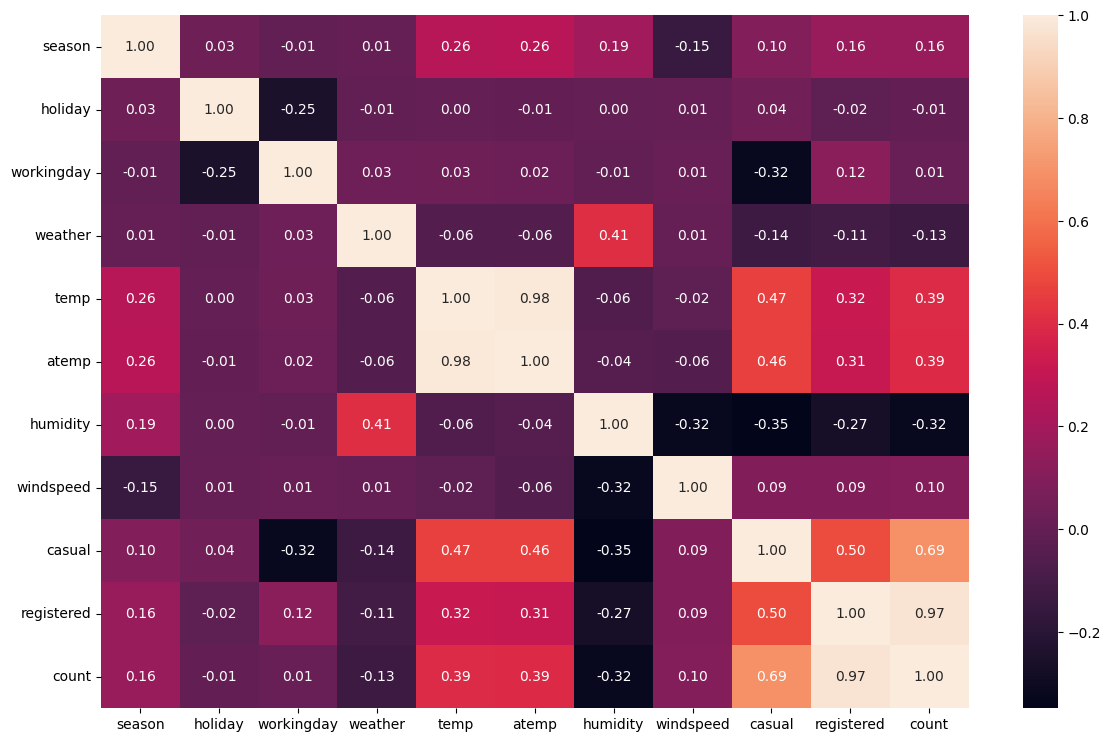

In [ ]:
df_corr = df.corr()
plt.figure(figsize=(14,9))
sns.heatmap(df_corr, annot=True, fmt=".2f")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

def generate_matriz_confusion(test_labels, test_predictions_labels):
  cm = confusion_matrix(test_labels, test_predictions_labels)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Rótulos Previstos")
  plt.ylabel("Rótulos Verdadeiros")
  plt.title("Matriz de Confusão")
  plt.show()

In [ ]:
def calcule_metrics_classification(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")
  print(f"ROC AUC: {roc_auc}")

In [ ]:
def plot_auc_ap(y_test, predictions):
  fpr, tpr, _ = roc_curve(y_test, predictions)
  roc_auc = roc_auc_score(y_test, predictions)

  precision, recall, _ = precision_recall_curve(y_test, predictions)
  ap = average_precision_score(y_test, predictions)

  plt.figure(figsize=(10, 5))

  # Curva ROC
  plt.subplot(1, 2, 1)
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('Taxa de Falso Positivo')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('Curva ROC')
  plt.legend(loc='lower right')

  # Curva Precision-Recall
  plt.subplot(1, 2, 2)
  plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap:.2f}')
  plt.xlabel('Revocação (Recall)')
  plt.ylabel('Precisão (Precision)')
  plt.title('Curva Precision-Recall')
  plt.legend(loc='lower left')

  plt.tight_layout()
  plt.show()

In [ ]:
def train_and_metrics(model, X_train, y_train, X_test, y_test):
  all_predictions = []
  all_true_labels = []

  all_accuracy = []
  all_precision = []
  all_recall = []
  all_f1 = []
  all_roc_auc = []

  best_metric_value = -np.inf
  best_model = None

  cv = KFold(n_splits = 5, shuffle=True, random_state = 42)
  for n_folder, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
      X_train_fold, X_valid = X.iloc[train_index], X.iloc[test_index]
      y_train_fold, y_valid = y.iloc[train_index], y.iloc[test_index]

      model.fit(X_train_fold, y_train_fold)

      predictions = model.predict(X_valid)

      print(f'\nMatriz de confusão para o folder {n_folder}')
      generate_matriz_confusion(y_valid, predictions)

      accuracy = accuracy_score(y_valid, predictions)
      precision = precision_score(y_valid, predictions)
      recall = recall_score(y_valid, predictions)
      f1 = f1_score(y_valid, predictions)
      roc_auc = roc_auc_score(y_valid, predictions)

      print(f"Accuracy: {accuracy}")
      print(f"Precision: {precision}")
      print(f"Recall: {recall}")
      print(f"F1-score: {f1}")
      print(f"ROC AUC: {roc_auc}")

      all_accuracy.append(accuracy)
      all_precision.append(precision)
      all_recall.append(recall)
      all_f1.append(f1)
      all_roc_auc.append(roc_auc)

      if accuracy > best_metric_value:
          best_metric_value = accuracy
          best_model = model

      all_predictions.extend(predictions)
      all_true_labels.extend(y_valid)

  accuracy = accuracy_score(all_true_labels, all_predictions)
  precision = precision_score(all_true_labels, all_predictions)
  recall = recall_score(all_true_labels, all_predictions)
  f1 = f1_score(all_true_labels, all_predictions)
  roc_auc = roc_auc_score(all_true_labels, all_predictions)

  print('\n--------Métricas gerais (média) para a predição dos 5 folders--------:')
  calcule_metrics_classification(all_true_labels, all_predictions)

  predictions = rf_model.predict(X_test)
  generate_matriz_confusion(y_test, predictions)
  print()

  plot_auc_ap(y_test, predictions)
  print()

  return best_model

# Processamento dos dados

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

In [ ]:
columns = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'registered', 'casual']
columns = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'day', 'hour', 'registered', 'casual']

In [ ]:
X = df[columns]
y = df['count']

# Classificação

> Classificando quando será alugado 150 ou mais bicicletas no dia



In [ ]:
df['count'].value_counts()

5.0      169
4.0      149
3.0      144
6.0      135
2.0      132
        ... 
801.0      1
629.0      1
825.0      1
589.0      1
636.0      1
Name: count, Length: 822, dtype: int64

In [ ]:
max(df['count']), min(df['count'])

(977.0, 1.0)

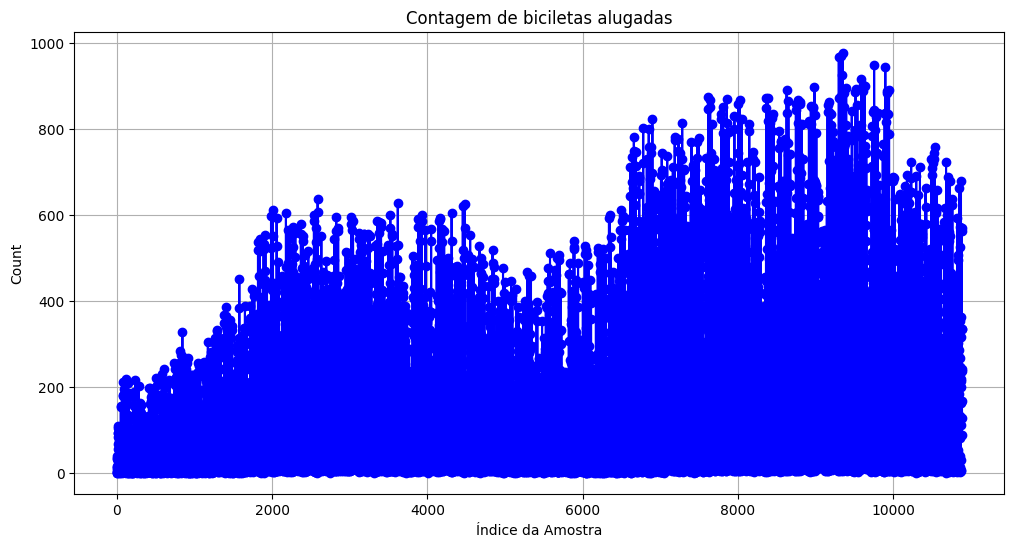

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['count'], marker='o', linestyle='-', color='b')
plt.title('Contagem de biciletas alugadas')
plt.xlabel('Índice da Amostra')
plt.ylabel('Count')
plt.grid(True)

plt.show()

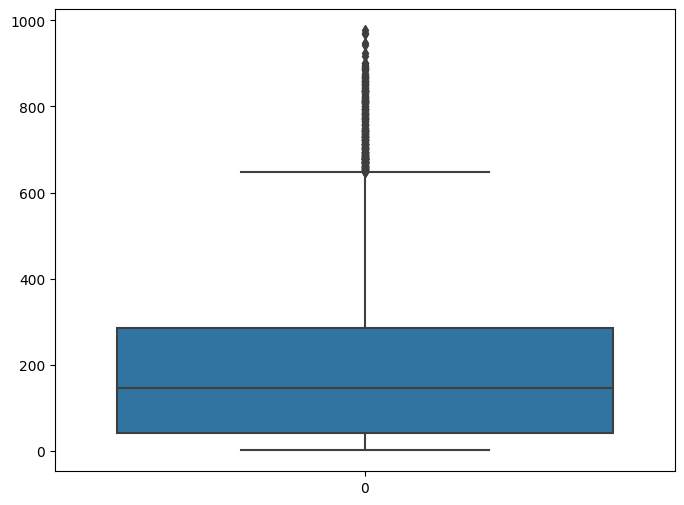

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df['count'], orient="v")
plt.show()

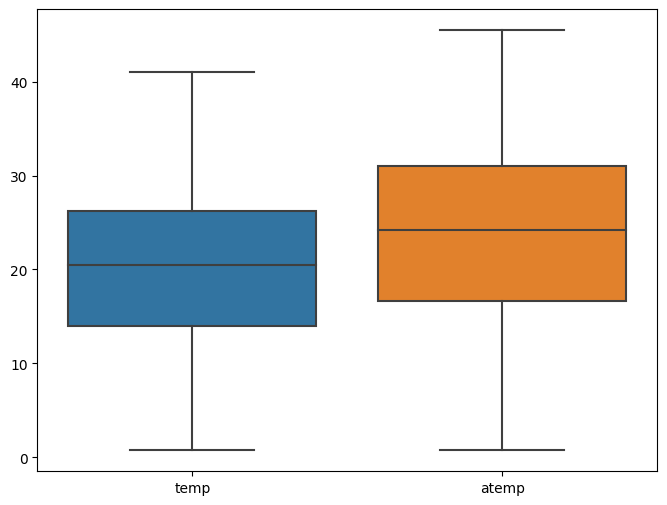

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[['temp','atemp']],
            orient='v')
plt.show()

In [ ]:
limiar = 150
df['demand_class'] = (df['count'] > limiar).astype(int)

columns_classification = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'month', 'day', 'hour', 'registered', 'casual']
X = df[columns_classification]
y = df['demand_class']

In [ ]:
df = df.dropna()

In [ ]:
y.value_counts()

0    5571
1    5315
Name: demand_class, dtype: int64

In [ ]:
X.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
month         0
day           0
hour          0
registered    0
casual        0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 456)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)

## Random Forest


Matriz de confusão para o folder 0


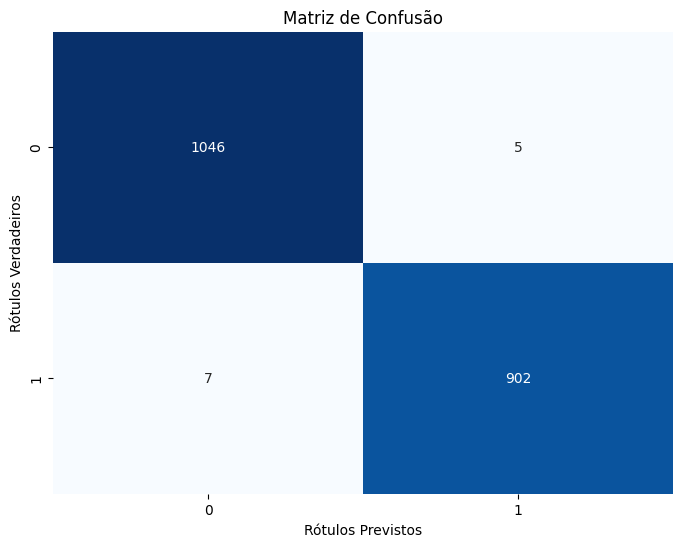

Accuracy: 0.9938775510204082
Precision: 0.9944873208379272
Recall: 0.9922992299229924
F1-score: 0.9933920704845816
ROC AUC: 0.9937709279967006

Matriz de confusão para o folder 1


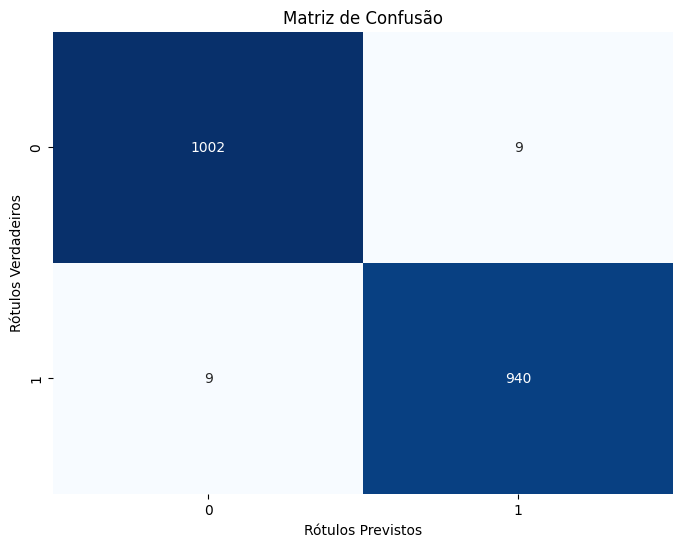

Accuracy: 0.9908163265306122
Precision: 0.9905163329820864
Recall: 0.9905163329820864
F1-score: 0.9905163329820864
ROC AUC: 0.9908071279153755

Matriz de confusão para o folder 2


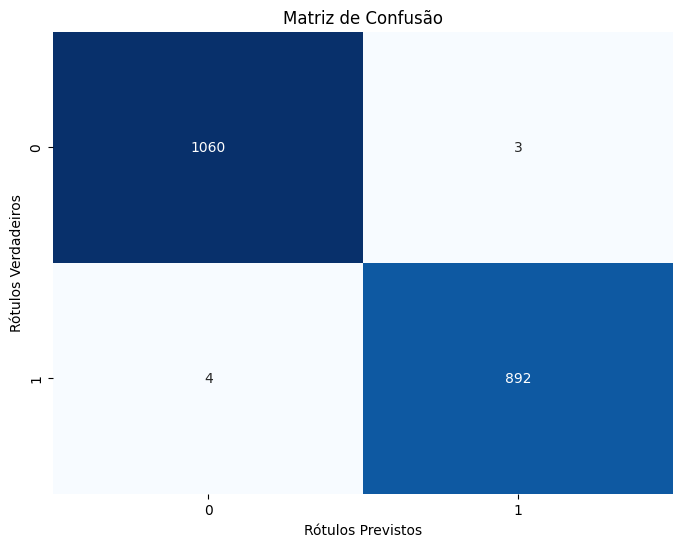

Accuracy: 0.9964267483409903
Precision: 0.9966480446927374
Recall: 0.9955357142857143
F1-score: 0.9960915689558906
ROC AUC: 0.9963567564843436

Matriz de confusão para o folder 3


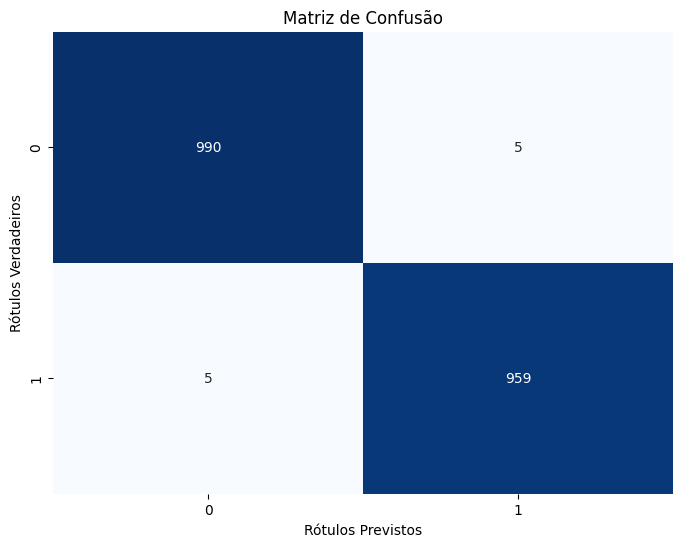

Accuracy: 0.9948953547728433
Precision: 0.9948132780082988
Recall: 0.9948132780082988
F1-score: 0.9948132780082988
ROC AUC: 0.9948940761900791

Matriz de confusão para o folder 4


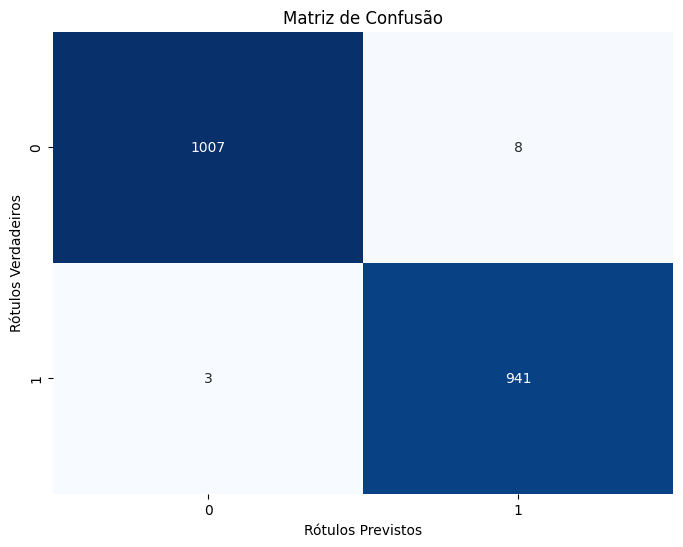

Accuracy: 0.9943848902501277
Precision: 0.9915700737618546
Recall: 0.996822033898305
F1-score: 0.99418911780243
ROC AUC: 0.9944701302496451

--------Métricas gerais (média) para a predição dos 5 folders--------:
Accuracy: 0.9940798203531693
Precision: 0.9935677530017153
Recall: 0.993993993993994
F1-score: 0.9937808277932663
ROC AUC: 0.994075867493589


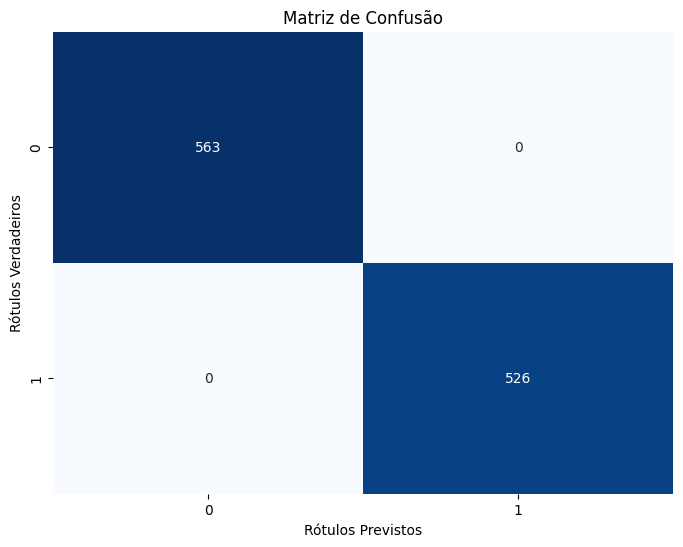

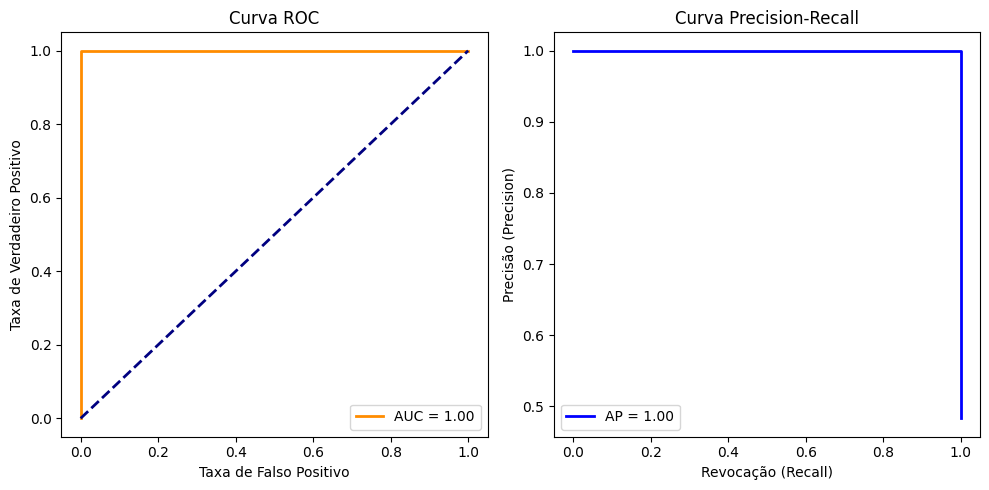

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 123)
best_rf_model = train_and_metrics(rf_model, X_train, y_train, X_test, y_test)

## SVM


Matriz de confusão para o folder 0


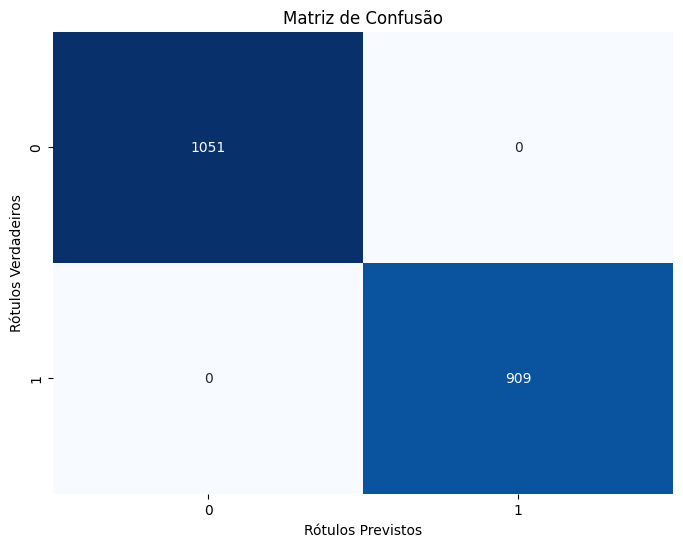

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0

Matriz de confusão para o folder 1


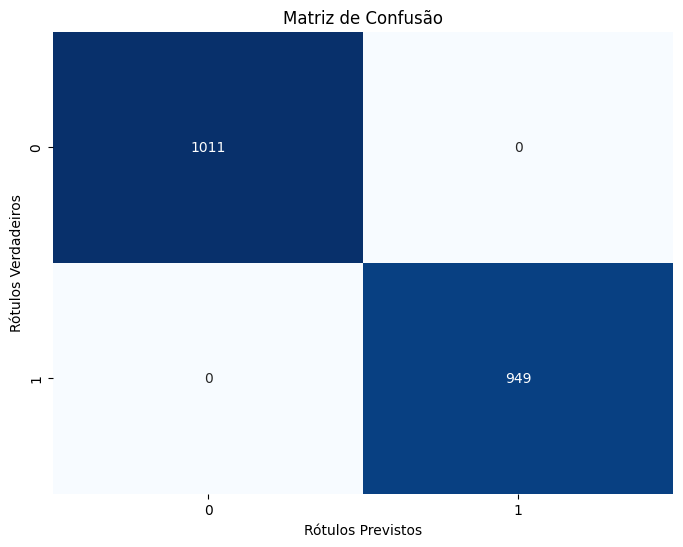

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0

Matriz de confusão para o folder 2


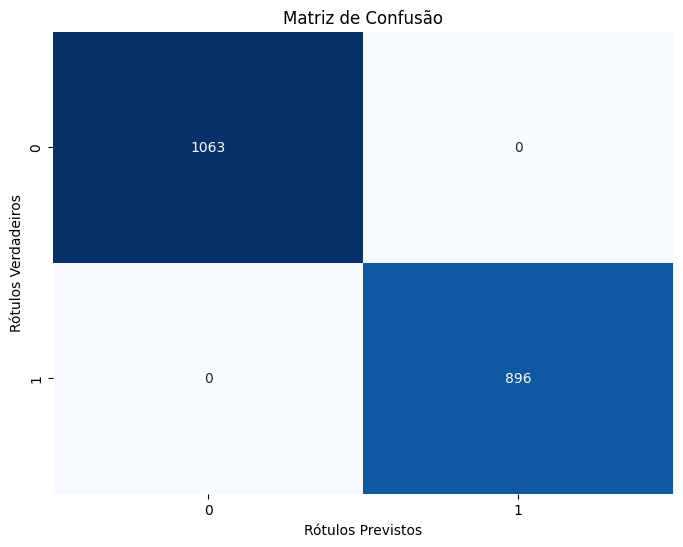

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0

Matriz de confusão para o folder 3


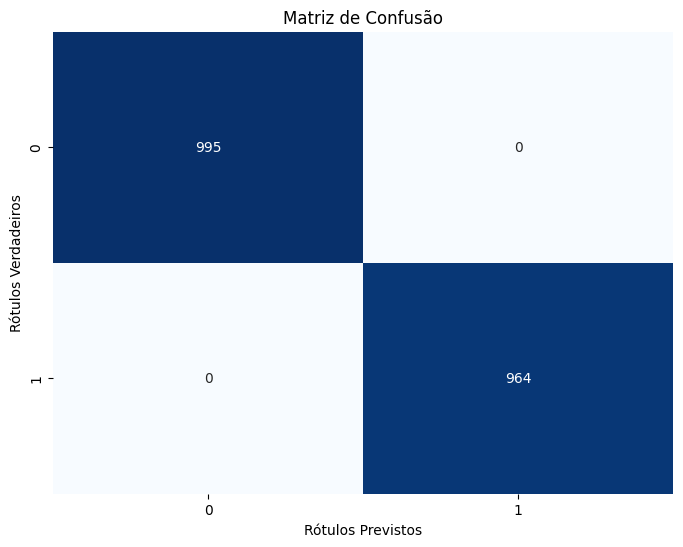

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0

Matriz de confusão para o folder 4


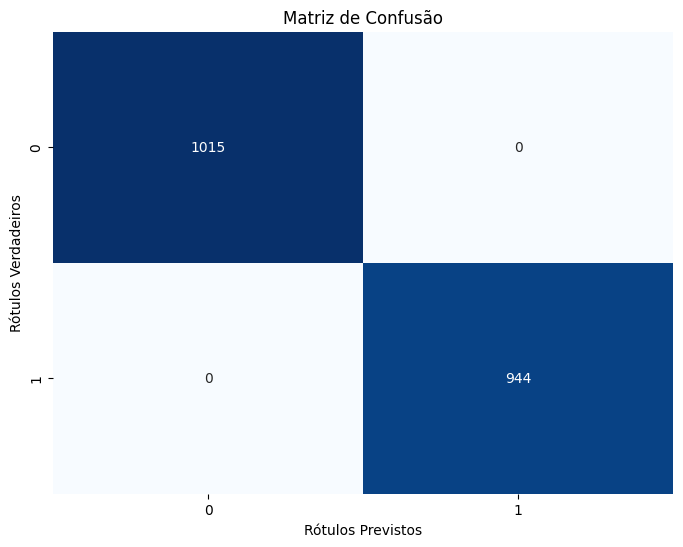

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0

--------Métricas gerais (média) para a predição dos 5 folders--------:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0


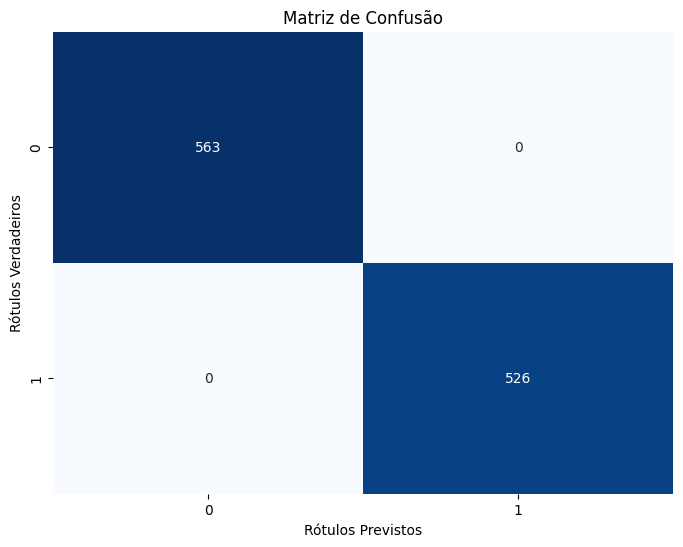

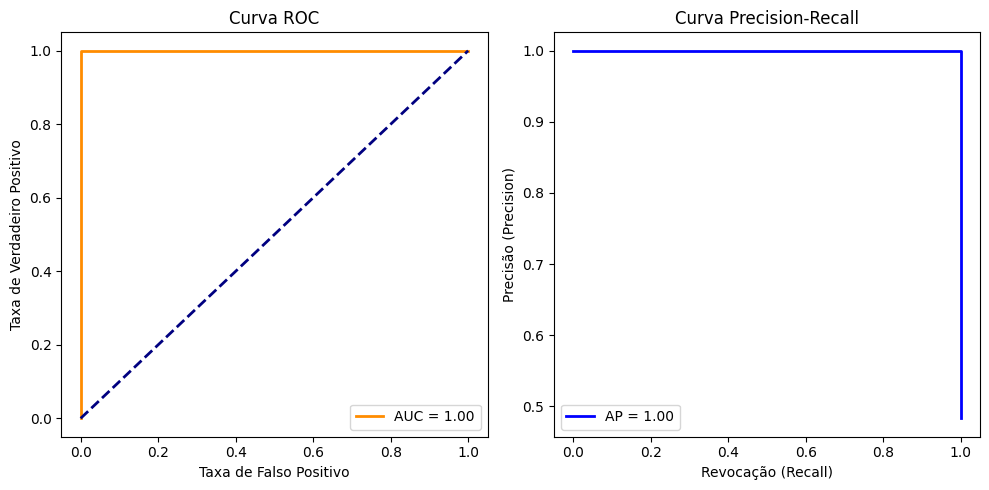

In [ ]:
from sklearn.svm import SVC
svc_model = SVC(kernel='linear', C = 1.0, random_state = 548)

best_svc_model = train_and_metrics(svc_model, X_train, y_train, X_test, y_test)

## Rede Neural

### Rede Bayesiana

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_normalized = scaler.fit_transform(X_train)


Matriz de confusão para o folder 0


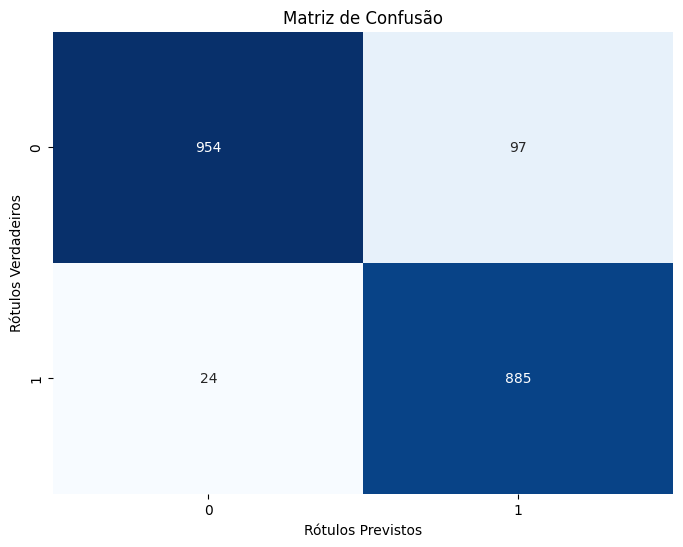

Accuracy: 0.938265306122449
Precision: 0.9012219959266803
Recall: 0.9735973597359736
F1-score: 0.9360126916975144
ROC AUC: 0.9406521527509555

Matriz de confusão para o folder 1


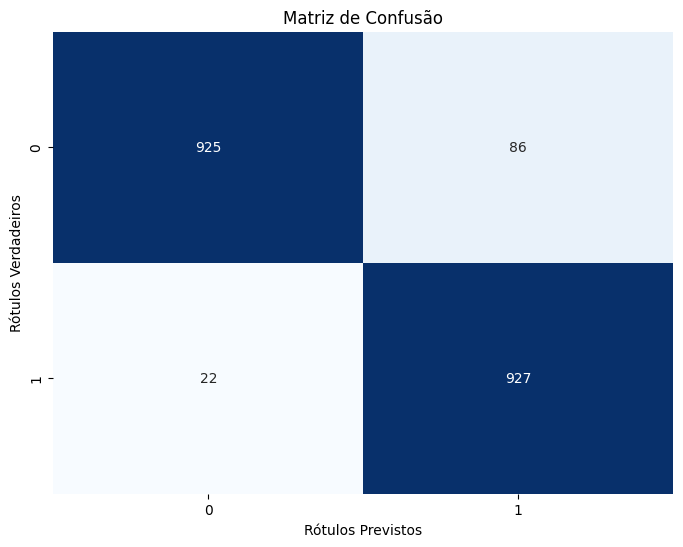

Accuracy: 0.9448979591836735
Precision: 0.9151036525172754
Recall: 0.9768177028451
F1-score: 0.944954128440367
ROC AUC: 0.9458767050328368

Matriz de confusão para o folder 2


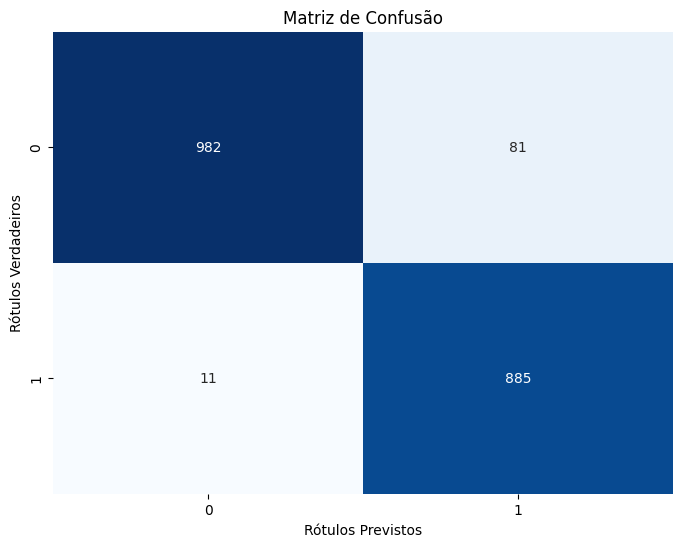

Accuracy: 0.9530372639101582
Precision: 0.9161490683229814
Recall: 0.9877232142857143
F1-score: 0.9505907626208377
ROC AUC: 0.9557618893629889

Matriz de confusão para o folder 3


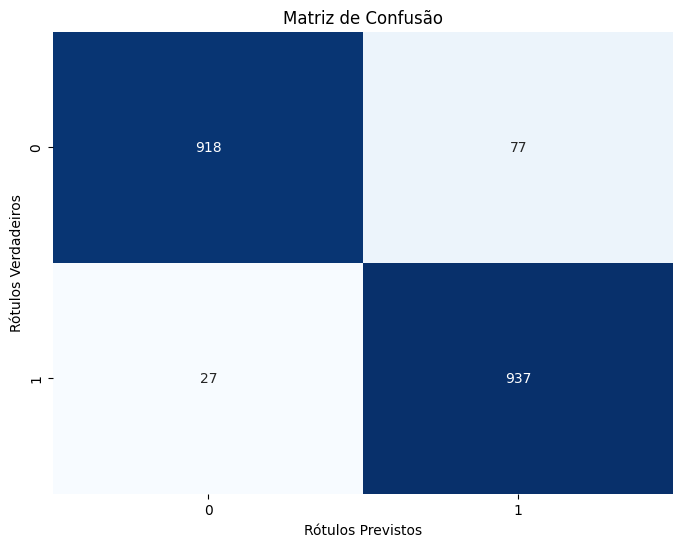

Accuracy: 0.9469116896375702
Precision: 0.9240631163708086
Recall: 0.9719917012448133
F1-score: 0.9474216380182002
ROC AUC: 0.9473023832857232

Matriz de confusão para o folder 4


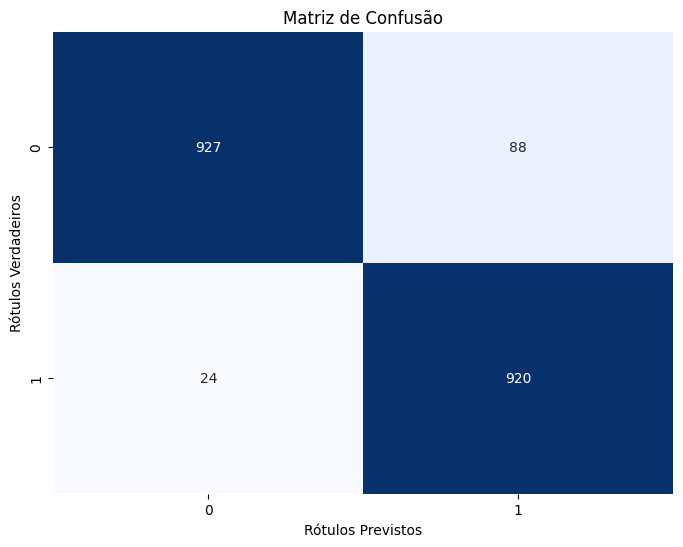

Accuracy: 0.9428279734558448
Precision: 0.9126984126984127
Recall: 0.9745762711864406
F1-score: 0.9426229508196721
ROC AUC: 0.9439383818986391

--------Métricas gerais (média) para a predição dos 5 folders--------:
Accuracy: 0.9451873022353782
Precision: 0.9139072847682119
Recall: 0.9768339768339769
F1-score: 0.9443234836702956
ROC AUC: 0.9466448365182543


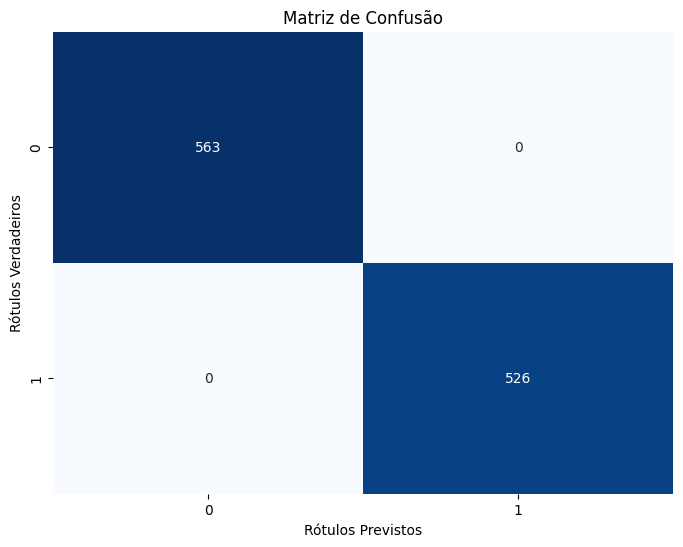

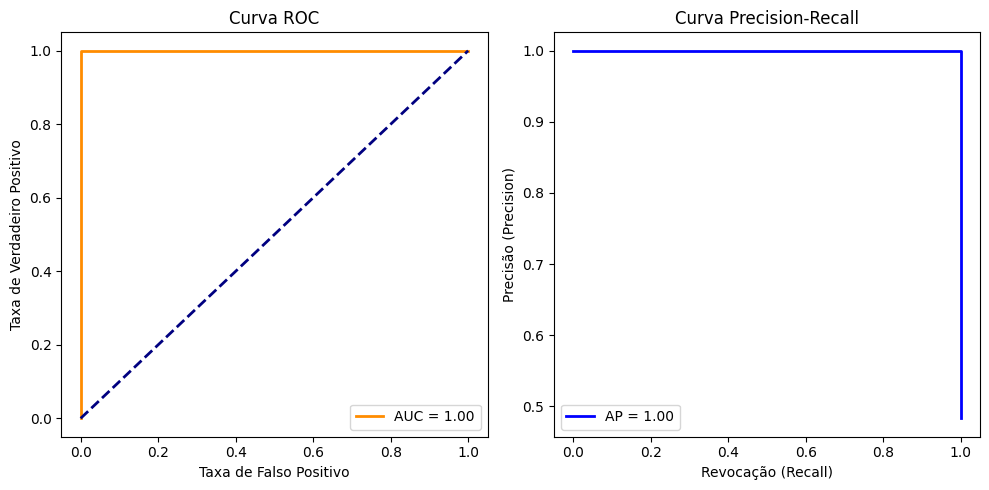

In [ ]:
from sklearn.naive_bayes import MultinomialNB
bayes_model = MultinomialNB()

best_bayes_model = train_and_metrics(bayes_model, X_train, y_train, X_test, y_test)

In [ ]:
# scaler = StandardScaler()
# X_train_normalized = scaler.fit_transform(X_train)

In [ ]:
# X_train_normalized.shape

In [ ]:
y_train

10805    1
133      0
3815     0
6739     0
10507    0
        ..
9116     0
10735    1
6186     0
10841    0
613      1
Name: demand_class, Length: 9797, dtype: int64

### Convolucional

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

(9797, 13, 1)

In [ ]:
name_checkpoint_best_model = 'best_model.h5'

In [ ]:
X_train.shape, y_train.shape

((9797, 13), (9797,))

In [ ]:
!pip install tensorflow_addons

import tensorflow_addons as tfa
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # soma dos verdadeiros positivos
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # soma dos verdadeiros positivos + falsos negativos
    recall = true_positives / (possible_positives + K.epsilon()) # cálculo do recall
    return recall

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1))) # soma dos verdadeiros negativos
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1))) # soma dos verdadeiros negativos + falsos positivos
    specificity = true_negatives / (possible_negatives + K.epsilon()) # cálculo da especificidade
    return specificity

In [ ]:
X_train.shape

(9797, 13)

Epoch 1/20
245/245 [==============================] - ETA: 0s - loss: 0.2841 - mae: 0.2060 - accuracy: 1.0000 - Recall: 0.8786 - Precision: 0.8791 - Specificity: 0.9965 - AUC: 0.9563
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 8s 16ms/step - loss: 0.2841 - mae: 0.2060 - accuracy: 1.0000 - Recall: 0.8786 - Precision: 0.8791 - Specificity: 0.9965 - AUC: 0.9563 - val_loss: 0.0953 - val_mae: 0.0755 - val_accuracy: 1.0000 - val_Recall: 0.9885 - val_Precision: 0.9518 - val_Specificity: 1.0000 - val_AUC: 0.9983
Epoch 2/20
  8/245 [..............................] - ETA: 1s - loss: 0.1225 - mae: 0.0828 - accuracy: 1.0000 - Recall: 0.9615 - Precision: 0.9091 - Specificity: 1.0000 - AUC: 0.9923

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/245 [============================>.] - ETA: 0s - loss: 0.0863 - mae: 0.0621 - accuracy: 1.0000 - Recall: 0.9640 - Precision: 0.9645 - Specificity: 1.0000 - AUC: 0.9962
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0859 - mae: 0.0619 - accuracy: 1.0000 - Recall: 0.9645 - Precision: 0.9650 - Specificity: 1.0000 - AUC: 0.9962 - val_loss: 0.0556 - val_mae: 0.0432 - val_accuracy: 1.0000 - val_Recall: 0.9697 - val_Precision: 0.9968 - val_Specificity: 1.0000 - val_AUC: 0.9993
Epoch 3/20
242/245 [============================>.] - ETA: 0s - loss: 0.0601 - mae: 0.0414 - accuracy: 1.0000 - Recall: 0.9762 - Precision: 0.9770 - Specificity: 1.0000 - AUC: 0.9980
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 4ms/step - loss: 0.0606 - mae: 0.0417 - accuracy: 1.0000 - Recall: 0.9765 - Precision: 0.9757 - Specificity: 1.0000 - AUC: 0.9980 - val_loss: 0.0405 - val_mae: 0.0324 - val

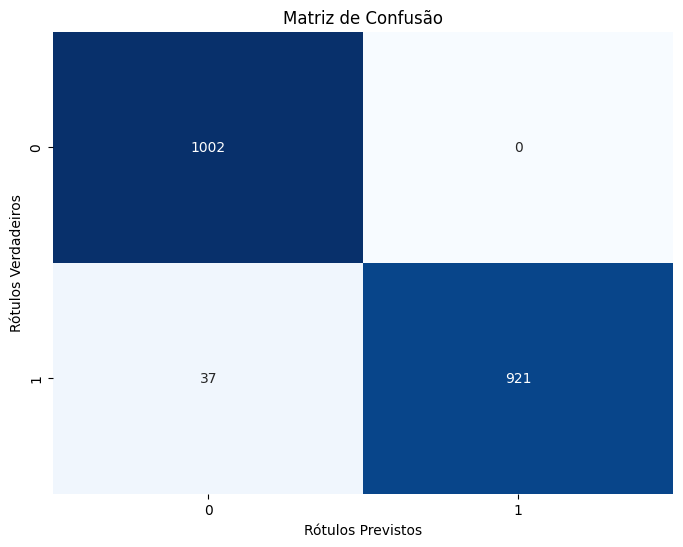

Accuracy: 0.9811224489795919
Precision: 1.0
Recall: 0.9613778705636743
F1-score: 0.9803086748270357
ROC AUC: 0.9806889352818371
Epoch 1/20
238/245 [============================>.] - ETA: 0s - loss: 0.2880 - mae: 0.2109 - accuracy: 1.0000 - Recall: 0.8470 - Precision: 0.8971 - Specificity: 0.9951 - AUC: 0.9568
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 4s 7ms/step - loss: 0.2827 - mae: 0.2072 - accuracy: 1.0000 - Recall: 0.8499 - Precision: 0.8994 - Specificity: 0.9965 - AUC: 0.9586 - val_loss: 0.1013 - val_mae: 0.0793 - val_accuracy: 1.0000 - val_Recall: 0.9468 - val_Precision: 0.9902 - val_Specificity: 1.0000 - val_AUC: 0.9976
Epoch 2/20
 46/245 [====>.........................] - ETA: 0s - loss: 0.0929 - mae: 0.0734 - accuracy: 1.0000 - Recall: 0.9577 - Precision: 0.9776 - Specificity: 1.0000 - AUC: 0.9974

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/245 [============================>.] - ETA: 0s - loss: 0.0861 - mae: 0.0633 - accuracy: 1.0000 - Recall: 0.9653 - Precision: 0.9656 - Specificity: 1.0000 - AUC: 0.9965
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 4ms/step - loss: 0.0854 - mae: 0.0628 - accuracy: 1.0000 - Recall: 0.9663 - Precision: 0.9658 - Specificity: 1.0000 - AUC: 0.9965 - val_loss: 0.0594 - val_mae: 0.0461 - val_accuracy: 1.0000 - val_Recall: 0.9760 - val_Precision: 0.9926 - val_Specificity: 1.0000 - val_AUC: 0.9990
Epoch 3/20
232/245 [===========================>..] - ETA: 0s - loss: 0.0571 - mae: 0.0420 - accuracy: 1.0000 - Recall: 0.9758 - Precision: 0.9750 - Specificity: 1.0000 - AUC: 0.9984
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 4ms/step - loss: 0.0560 - mae: 0.0413 - accuracy: 1.0000 - Recall: 0.9760 - Precision: 0.9755 - Specificity: 1.0000 - AUC: 0.9985 - val_loss: 0.0466 - val_mae: 0.0351 - val

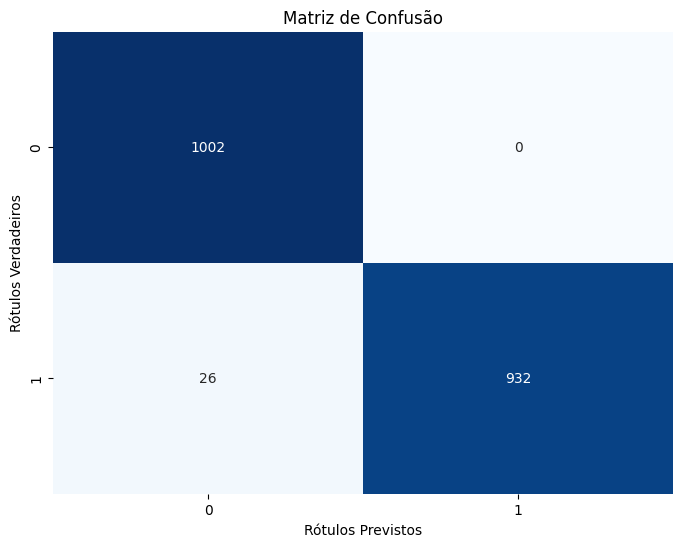

Accuracy: 0.986734693877551
Precision: 1.0
Recall: 0.9728601252609603
F1-score: 0.9862433862433863
ROC AUC: 0.9864300626304802
Epoch 1/20
238/245 [============================>.] - ETA: 0s - loss: 0.2884 - mae: 0.2106 - accuracy: 1.0000 - Recall: 0.9108 - Precision: 0.8631 - Specificity: 0.9956 - AUC: 0.9582
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 3s 6ms/step - loss: 0.2834 - mae: 0.2071 - accuracy: 1.0000 - Recall: 0.9136 - Precision: 0.8655 - Specificity: 0.9968 - AUC: 0.9598 - val_loss: 0.1080 - val_mae: 0.0848 - val_accuracy: 1.0000 - val_Recall: 0.9781 - val_Precision: 0.9484 - val_Specificity: 1.0000 - val_AUC: 0.9967
Epoch 2/20
 43/245 [====>.........................] - ETA: 0s - loss: 0.1067 - mae: 0.0818 - accuracy: 1.0000 - Recall: 0.9555 - Precision: 0.9643 - Specificity: 1.0000 - AUC: 0.9956

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


233/245 [===========================>..] - ETA: 0s - loss: 0.0794 - mae: 0.0604 - accuracy: 1.0000 - Recall: 0.9733 - Precision: 0.9736 - Specificity: 1.0000 - AUC: 0.9975
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 4ms/step - loss: 0.0781 - mae: 0.0595 - accuracy: 1.0000 - Recall: 0.9734 - Precision: 0.9744 - Specificity: 1.0000 - AUC: 0.9976 - val_loss: 0.0621 - val_mae: 0.0477 - val_accuracy: 1.0000 - val_Recall: 0.9603 - val_Precision: 0.9924 - val_Specificity: 1.0000 - val_AUC: 0.9989
Epoch 3/20
236/245 [===========================>..] - ETA: 0s - loss: 0.0500 - mae: 0.0377 - accuracy: 1.0000 - Recall: 0.9816 - Precision: 0.9808 - Specificity: 1.0000 - AUC: 0.9989
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 4ms/step - loss: 0.0498 - mae: 0.0375 - accuracy: 1.0000 - Recall: 0.9817 - Precision: 0.9810 - Specificity: 1.0000 - AUC: 0.9990 - val_loss: 0.0420 - val_mae: 0.0329 - val

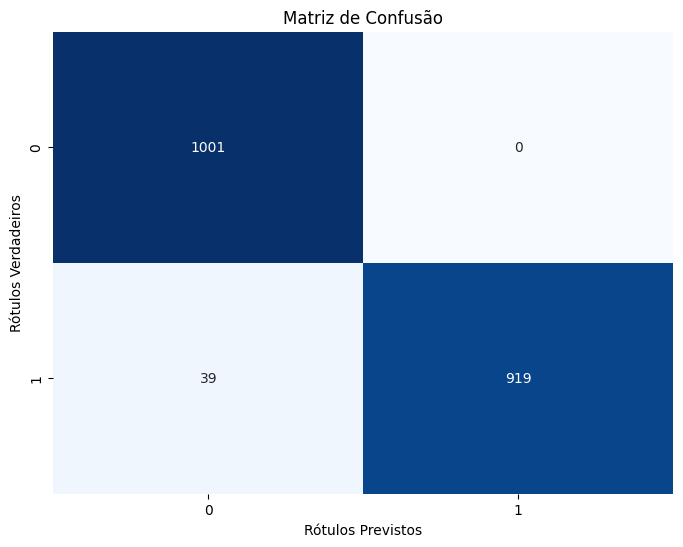

Accuracy: 0.9800918836140888
Precision: 1.0
Recall: 0.9592901878914405
F1-score: 0.9792221630261055
ROC AUC: 0.9796450939457202
Epoch 1/20
241/245 [============================>.] - ETA: 0s - loss: 0.2584 - mae: 0.1881 - accuracy: 1.0000 - Recall: 0.9084 - Precision: 0.8803 - Specificity: 0.9985 - AUC: 0.9648
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 3s 6ms/step - loss: 0.2556 - mae: 0.1861 - accuracy: 1.0000 - Recall: 0.9094 - Precision: 0.8820 - Specificity: 0.9985 - AUC: 0.9656 - val_loss: 0.1321 - val_mae: 0.0886 - val_accuracy: 1.0000 - val_Recall: 1.0000 - val_Precision: 0.8854 - val_Specificity: 1.0000 - val_AUC: 0.9983
Epoch 2/20
 46/245 [====>.........................] - ETA: 0s - loss: 0.1000 - mae: 0.0732 - accuracy: 1.0000 - Recall: 0.9593 - Precision: 0.9579 - Specificity: 1.0000 - AUC: 0.9951

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


244/245 [============================>.] - ETA: 0s - loss: 0.0763 - mae: 0.0565 - accuracy: 1.0000 - Recall: 0.9696 - Precision: 0.9714 - Specificity: 1.0000 - AUC: 0.9973
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 4ms/step - loss: 0.0763 - mae: 0.0565 - accuracy: 1.0000 - Recall: 0.9695 - Precision: 0.9715 - Specificity: 1.0000 - AUC: 0.9973 - val_loss: 0.0474 - val_mae: 0.0382 - val_accuracy: 1.0000 - val_Recall: 0.9916 - val_Precision: 0.9804 - val_Specificity: 1.0000 - val_AUC: 0.9995
Epoch 3/20
245/245 [==============================] - ETA: 0s - loss: 0.0616 - mae: 0.0420 - accuracy: 1.0000 - Recall: 0.9715 - Precision: 0.9746 - Specificity: 1.0000 - AUC: 0.9978
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0616 - mae: 0.0420 - accuracy: 1.0000 - Recall: 0.9715 - Precision: 0.9746 - Specificity: 1.0000 - AUC: 0.9978 - val_loss: 0.0379 - val_mae: 0.0303 - val

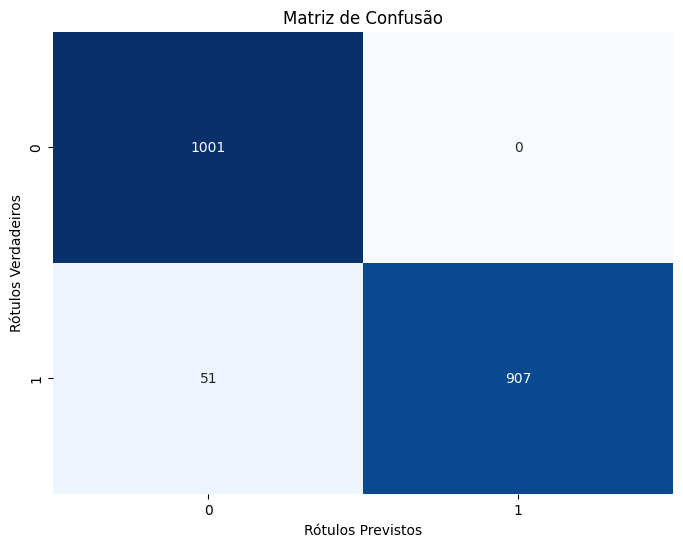

Accuracy: 0.9739663093415007
Precision: 1.0
Recall: 0.9467640918580376
F1-score: 0.9726541554959786
ROC AUC: 0.9733820459290188
Epoch 1/20
234/245 [===========================>..] - ETA: 0s - loss: 0.3023 - mae: 0.2215 - accuracy: 1.0000 - Recall: 0.8213 - Precision: 0.9004 - Specificity: 0.9958 - AUC: 0.9528
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to best_model.h5
245/245 [==============================] - 3s 8ms/step - loss: 0.2936 - mae: 0.2154 - accuracy: 1.0000 - Recall: 0.8280 - Precision: 0.9037 - Specificity: 0.9965 - AUC: 0.9557 - val_loss: 0.1306 - val_mae: 0.0933 - val_accuracy: 1.0000 - val_Recall: 0.9979 - val_Precision: 0.8959 - val_Specificity: 1.0000 - val_AUC: 0.9979
Epoch 2/20
 28/245 [==>...........................] - ETA: 0s - loss: 0.1110 - mae: 0.0854 - accuracy: 1.0000 - Recall: 0.9569 - Precision: 0.9569 - Specificity: 1.0000 - AUC: 0.9956

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


231/245 [===========================>..] - ETA: 0s - loss: 0.0874 - mae: 0.0658 - accuracy: 1.0000 - Recall: 0.9654 - Precision: 0.9689 - Specificity: 1.0000 - AUC: 0.9967
Epoch 2: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 5ms/step - loss: 0.0859 - mae: 0.0646 - accuracy: 1.0000 - Recall: 0.9663 - Precision: 0.9691 - Specificity: 1.0000 - AUC: 0.9968 - val_loss: 0.0561 - val_mae: 0.0432 - val_accuracy: 1.0000 - val_Recall: 0.9572 - val_Precision: 1.0000 - val_Specificity: 1.0000 - val_AUC: 0.9997
Epoch 3/20
241/245 [============================>.] - ETA: 0s - loss: 0.0593 - mae: 0.0436 - accuracy: 1.0000 - Recall: 0.9764 - Precision: 0.9758 - Specificity: 1.0000 - AUC: 0.9983
Epoch 3: val_accuracy did not improve from 1.00000
245/245 [==============================] - 1s 4ms/step - loss: 0.0590 - mae: 0.0434 - accuracy: 1.0000 - Recall: 0.9768 - Precision: 0.9763 - Specificity: 1.0000 - AUC: 0.9983 - val_loss: 0.0393 - val_mae: 0.0313 - val

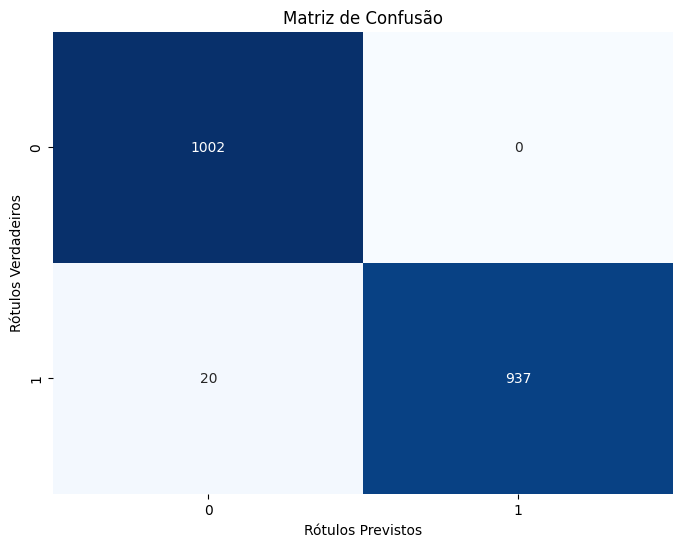

Accuracy: 0.9897907095456866
Precision: 1.0
Recall: 0.9791013584117032
F1-score: 0.9894403379091868
ROC AUC: 0.9895506792058516


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 789)
accuracies = []

# for train_index, test_index in cv.split(X_train, y_train):
#     X_train_neural, X_test_neural = X_train[train_index], X_train[test_index]
#     y_train_neural, y_test_neural = y_train.iloc[train_index], y_train.iloc[test_index]
for n_folder, (train_index, test_index) in enumerate(cv.split(X_train, y_train)):
    X_train_neural, X_test_neural = X_train[train_index], X_train[test_index]
    y_train_neural, y_test_neural = y_train.iloc[train_index], y_train.iloc[test_index]

    model_checkpoint = ModelCheckpoint(name_checkpoint_best_model, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2], )),
        Conv1D(64, 3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy',
                      metrics = [ tf.keras.metrics.MeanAbsoluteError(name='mae'),
                                  tf.keras.metrics.CategoricalAccuracy(name='accuracy', dtype=None),
                                  tf.keras.metrics.Recall(name='Recall'),
                                  tf.keras.metrics.Precision(name='Precision'),
                                  tf.keras.metrics.SpecificityAtSensitivity(name='Specificity', sensitivity = 0.5),
                                  tf.keras.metrics.AUC(curve="ROC", summation_method="interpolation", name="AUC")
                                  ])

    model.fit(X_train_neural, y_train_neural, epochs = 20, batch_size = 32,
              validation_data=(X_test_neural, y_test_neural), callbacks=[early_stopping, model_checkpoint], verbose=1 )
    my_tensor = tf.convert_to_tensor(X_test_neural, dtype=tf.float16)
    previsoes = model.predict(my_tensor)

    y_pred_classes = (previsoes > 0.9)
    y_val_classes = np.round(y_test_neural)
    generate_matriz_confusion(y_val_classes, y_pred_classes)
    calcule_metrics_classification(y_val_classes, y_pred_classes)

In [ ]:
best_model = keras.models.load_model(name_checkpoint_best_model)

In [ ]:
X_test_normalized = scaler.transform(X_test)
y_pred = best_model.predict(X_test_normalized)

y_pred_binary = (y_pred > 0.9).astype(int)

35/35 [==============================] - 0s 2ms/step


In [ ]:
print('Métricas gerais (média) para a predição dos 5 folders com Rede Neural:\n')
calcule_metrics_classification(y_test, y_pred_binary)

Métricas gerais (média) para a predição dos 5 folders com Rede Neural:

Accuracy: 0.9412304866850322
Precision: 1.0
Recall: 0.8783269961977186
F1-score: 0.9352226720647774
ROC AUC: 0.9391634980988592


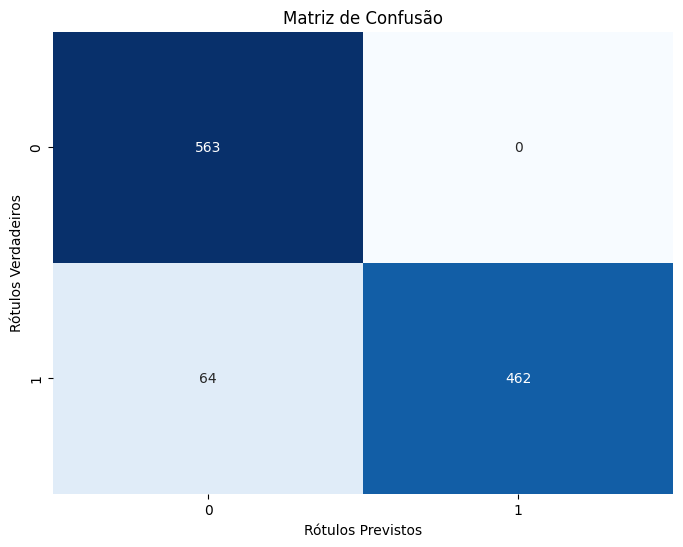

In [ ]:
generate_matriz_confusion(y_test, y_pred_binary)